<a href="https://colab.research.google.com/github/MatthewNg3416/-/blob/master/MWN_240715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# 240714


from email.mime import image
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader

import torch.optim as optim

from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final(dec1)



if __name__ == "__main__":
    print("unet:")
    model=UNet(in_channels=3,
               out_channels=1)


    print(next(model.parameters()).device)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(next(model.parameters()).device)

    # 数据预处理
    transform=transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ])

    # 加载Pascal VOC数据集
    train_dataset=VOCSegmentation(
        root='./data',
        year='2012',
        image_set='train',
        download=True,
        transform=transform,
        target_transform=transform
    )
    train_loader=DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True)

    criterion=nn.BCEWithLogitsLoss()
    optimizer=optim.Adam(model.parameters(),
                         lr=.001)
    # 训练循环
    num_epochs=10
    for epoch in range(num_epochs):
        model.train()
        epoch_loss=0
        for images,masks in train_loader:
            images=images.to(device)
            masks=masks.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,masks)
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, \
              Loss: {epoch_loss/len(train_loader)}")



    # print(model)

    # 模型评估
    model.eval()
    i=0
    with torch.no_grad():
        for images,masks in train_loader:
            images=images.to(device)
            masks=masks.to(device)
            outputs=model(images)
            #将结果保存为图片
            save_image(outputs,
                     'output{i}.png')
            i+=1
            if(i>10):
                break






unet:
cpu
cpu


100%|██████████| 1999639040/1999639040 [01:11<00:00, 27907057.33it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


KeyboardInterrupt: 

In [23]:
print("unet----")
print("----")
import torch.nn as nn
class Unet2(nn.Module):
  def __init__(self,in_channels,out_channels) -> None:
      super(Unet2,self).__init__()

      self.prt="prt"
      print("Unet init")

unet2 = Unet2(2,3)
print(unet2.parameters)
a = torch.tensor(2)
b = torch.tensor(3)
c = a+b
import pdb
# pdb.set_trace()
print(c)






unet----
----
Unet init
<bound method Module.parameters of Unet2()>
tensor(5)


torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


<ipython-input-9-b30171fbfd50>:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-9-b30171fbfd50>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


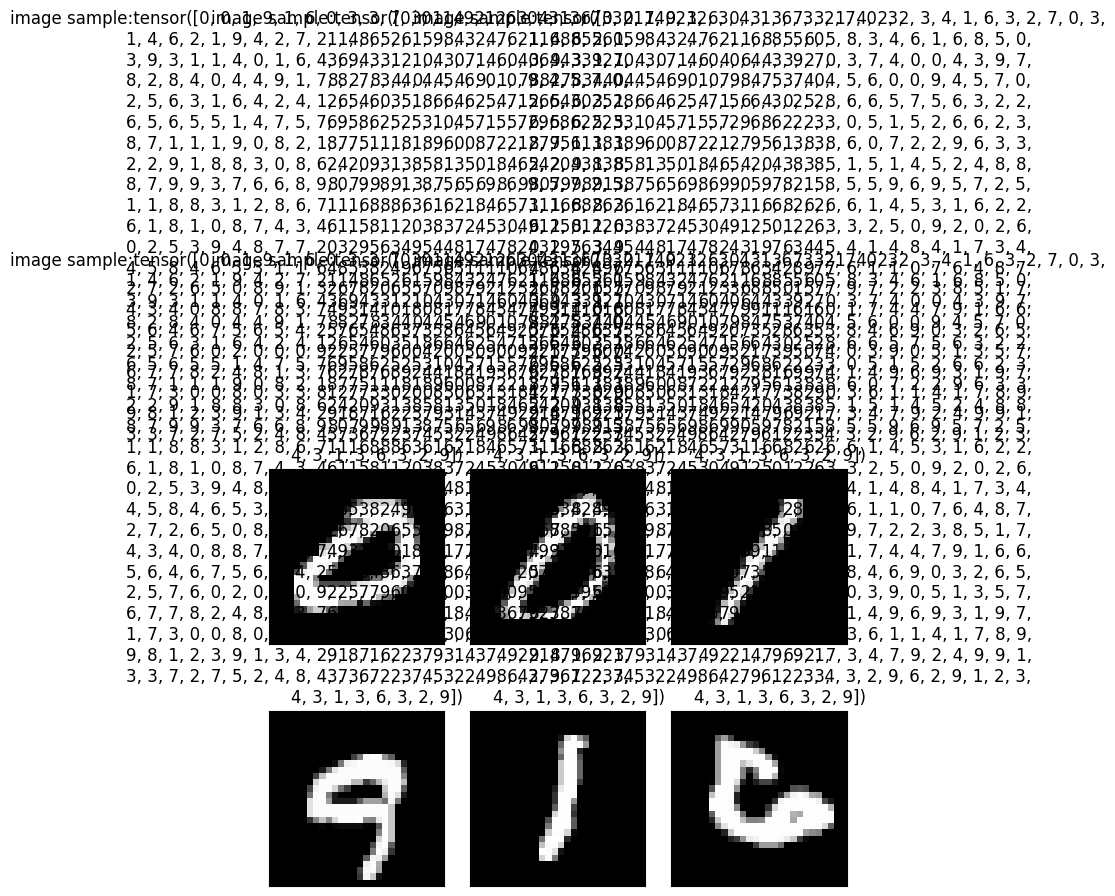

0 0 0.12115800380706787
0 10 0.09900099784135818
0 20 0.08769305050373077
0 30 0.08611047267913818
0 40 0.08168228715658188
0 50 0.07595182210206985
0 60 0.07613499462604523
0 70 0.07620171457529068
0 80 0.07424680888652802
0 90 0.07217663526535034
0 100 0.07378225773572922
0 110 0.07179595530033112
1 0 0.07101708650588989
1 10 0.07034548372030258
1 20 0.06910654157400131
1 30 0.06871325522661209
1 40 0.06961709260940552
1 50 0.06904783844947815
1 60 0.06541015207767487
1 70 0.06491640210151672
1 80 0.06493129581212997
1 90 0.06539421528577805
1 100 0.06470080465078354
1 110 0.06713398545980453
2 0 0.06461988389492035
2 10 0.06600481271743774
2 20 0.06228001043200493
2 30 0.062428344041109085
2 40 0.06334062665700912
2 50 0.06532486528158188
2 60 0.06318465620279312
2 70 0.06306026130914688
2 80 0.0618208646774292
2 90 0.06360172480344772
2 100 0.06340575963258743
2 110 0.06261477619409561


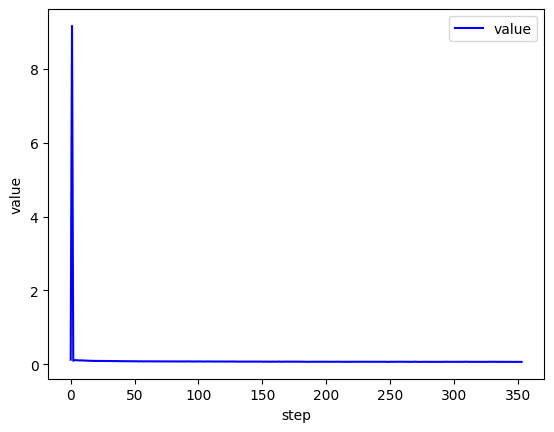

test acc: 0.556


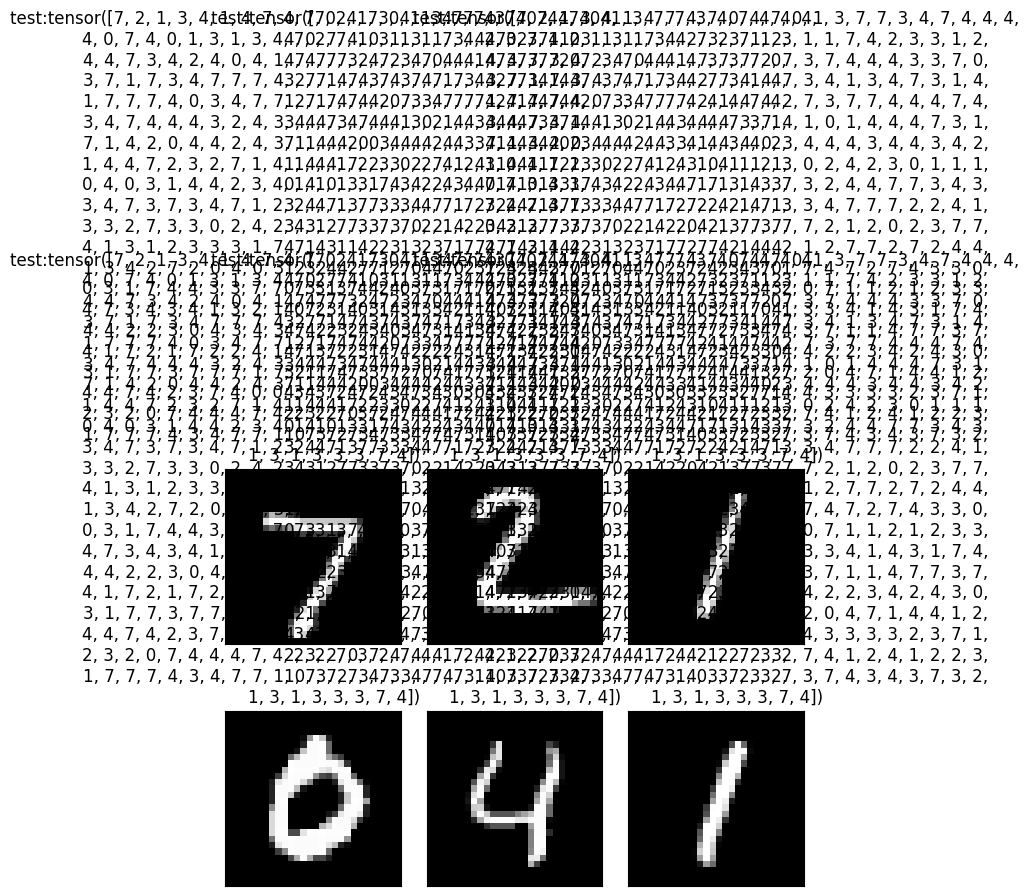

In [9]:

#
import torch
from matplotlib import pyplot as plt

def plot_curve(data):
  fig=plt.figure()
  plt.plot(range(len(data)),
           data,
           color='blue')
  plt.legend(['value'],
      loc="upper right")
  plt.xlabel('step')
  plt.ylabel('value')
  plt.show()


def plot_image(img,
    label,
    name):
  fig=plt.figure()
  for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(img[i][0]*0.3081+0.1307,cmap='gray',interpolation='none')
    plt.title("{}:{}".format(name,label))
    plt.xticks([])
    plt.yticks([])
  plt.show()


def one_hot(label,depth=10):
  out=torch.zeros(label.size(0),depth)
  idx=torch.LongTensor(label).view(-1,1)
  out.scatter_(dim=1,
        index=idx,
        value=1)
  return out


import  torch
from    torch import nn
from    torch.nn import functional as F
from    torch import optim

import  torchvision
from    matplotlib import pyplot as plt

# from    utils import plot_image, plot_curve, one_hot



batch_size = 512

# step1. load dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=False)

x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())
plot_image(x, y, 'image sample')



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # xw+b
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x: [b, 1, 28, 28]
        # h1 = relu(xw1+b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2+b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3+b3
        x = self.fc3(x)

        return x



net = Net()
# [w1, b1, w2, b2, w3, b3]
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.01)
# optimizer = optim.SGD(net.parameters(), lr=0.01)
# optimizer = optim.Adam(net.parameters(), lr=0.01)

train_loss = []
for epoch in range(3*1):

    for batch_idx, (x, y) in enumerate(train_loader):

        # x: [b, 1, 28, 28], y: [512]
        # [b, 1, 28, 28] => [b, 784]
        x = x.view(x.size(0), 28*28)
        # => [b, 10]
        out = net(x)
        # [b, 10]
        y_onehot = one_hot(y)
        # loss = mse(out, y_onehot)
        loss = F.mse_loss(out, y_onehot)

        optimizer.zero_grad()
        loss.backward()
        # w' = w - lr*grad
        optimizer.step()

        train_loss.append(loss.item())

        if batch_idx % 10==0:
            print(epoch, batch_idx, loss.item())

plot_curve(train_loss)
# we get optimal [w1, b1, w2, b2, w3, b3]


total_correct = 0
for x,y in test_loader:
    x  = x.view(x.size(0), 28*28)
    out = net(x)
    # out: [b, 10] => pred: [b]
    pred = out.argmax(dim=1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

total_num = len(test_loader.dataset)
acc = total_correct / total_num
print('test acc:', acc)

x, y = next(iter(test_loader))
out = net(x.view(x.size(0), 28*28))
pred = out.argmax(dim=1)
plot_image(x, pred, 'test')











